In [1]:
import pandas as pd
import tweepy 
from tweepy import OAuthHandler

In [2]:
def TwitterClient(): 
    # keys and tokens from the Twitter Dev Console 
    api_key = "xQGrEytN0KSsEERUlbA3Mwjdv"
    api_secret = "N7ModRAyQqtFkB4jvI1o0nCooyfSGfZZUAaIfHTQp3iiUGutKi"
    access = "3118781631-GnQENiXAMouhIuhas2ol14A4b9zyChTR927WZmW"
    access_secret = "frEmYjSFnETQka3sOtTb2x6oCOAkFHDmSivcgrqULytRL"

    # attempt authentication 
    try: 
        # create OAuthHandler object 
        auth = OAuthHandler(api_key, api_secret) 
        # set access token and secret 
        auth.set_access_token(access, access_secret) 
        # create tweepy API object to fetch tweets 
        api = tweepy.API(auth) 
    except: 
        print("Error: Authentication Failed") 

    return api #now we can make request to twitter using this api

In [3]:
api = TwitterClient()

#get tweets from a user and add the tweets to a dataframe
def get_tweets(user_name):
    tweets = []
    for tweet in tweepy.Cursor(api.user_timeline, id=user_name).items():
        tweets.append(tweet)
    df = pd.DataFrame(data=[tweet.text for tweet in tweets], columns=['Tweets'])
    return df

In [ ]:
jeff_tweets = get_tweets('JeffBezos')
jeff_tweets.columns = ['Jeff Bezos']

elon_tweets = get_tweets('elonmusk')
elon_tweets.columns = ['Elon Musk']

shaq_tweets = get_tweets('SHAQ')
shaq_tweets.columns = ["Shaquille O'Neal"]

snoop_tweets = get_tweets('SnoopDogg')
snoop_tweets.columns = ["Snoop Dogg"]

barack_tweets = get_tweets('BarackObama')
barack_tweets.columns = ["Barack Obama"]

will_tweets = get_tweets('willsmith')
will_tweets.columns = ["Will Smith"]

taylor_tweets = get_tweets('taylorswift13')
taylor_tweets.columns = ["Taylor Swift"]

slash_tweets = get_tweets('Slash')
slash_tweets.columns = ["Slash"]

wiz_tweets = get_tweets('wizkhalifa')
wiz_tweets.columns = ["Wiz Khalifa"]

nat_geo_tweets = get_tweets('natGeo')
nat_geo_tweets.columns = ["National Geographic"]

bbc_earth_tweets = get_tweets('BBCEarth')
bbc_earth_tweets.columns = ["BBC Earth"]

biden_tweets = get_tweets('JoeBiden')
biden_tweets.columns = ["Joe Biden"]

In [119]:
#combine all the dataframes into one
df = pd.concat([jeff_tweets, 
                elon_tweets, 
                shaq_tweets,
                snoop_tweets,
                barack_tweets,
                will_tweets,
                taylor_tweets,
                slash_tweets,
                wiz_tweets,
                nat_geo_tweets,
                bbc_earth_tweets,
                biden_tweets
            ], axis=1)

In [89]:
import re
from nltk.corpus import stopwords

def remove_punctuation(text):
    return re.sub('[^a-zA-Z]', ' ', str(text))

# convert to lower case
def lower_case(text):
    return text.lower()

# remove stop words
def remove_stop_words(text):
    stop_words = set(stopwords.words('english'))
    stop_words.update(["https", "co", "http", "'", "rt", "nan"])
    word_tokens = text.split()
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    return filtered_sentence

columns = df.columns.tolist()

# call all 3 functions and change the dataframe in a for loop
for i in range(len(df)):
    for name in columns:
        df[name][i] = remove_punctuation(df[name][i])
        df[name][i] = lower_case(df[name][i])
        df[name][i] = remove_stop_words(df[name][i])


In [90]:
df_strings = {}
for name in columns:
    df_strings[name] = " ".join([str(word) for item in df[name] for word in item])

In [91]:
from gensim import corpora, models, similarities
from collections import defaultdict

stop_words = set(stopwords.words('english'))
stop_words.update(["https", "co", "http", "'", "rt", "nan"])

# documents = list of each df_string
documents = []
for name in columns:
    documents.append(df_strings[name])

texts = [[word.lower() for word in document.split()
          if word.lower() not in stop_words]
         for document in documents]

frequency = defaultdict(int)

for text in texts:
    for token in text:
        frequency[token] += 1

texts = [[token for token in text if frequency[token] > 1] for text in texts]

dictionary = corpora.Dictionary(texts)

corpus = [dictionary.doc2bow(text) for text in texts]
lsi = models.LsiModel(corpus, id2word=dictionary, num_topics=2)


In [109]:
doc = ""
vec_bow = dictionary.doc2bow(doc.lower().split())

# convert the query to LSI space
vec_lsi = lsi[vec_bow]
index = similarities.MatrixSimilarity(lsi[corpus])

# perform a similarity query against the corpus
sims = index[vec_lsi]
sims = sorted(enumerate(sims), key=lambda item: -item[1])

#print sims but the names of the indexes and the points
for i in range(len(sims)):
    print(columns[sims[i][0]], sims[i][1])



Barack Obama 0.9373937
Jeff Bezos 0.36362413
Will Smith 0.31776047
Elon Musk 0.26819077
Taylor Swift 0.21603274
Shaquille O'Neal 0.01157698
Snoop Dogg -0.059441805


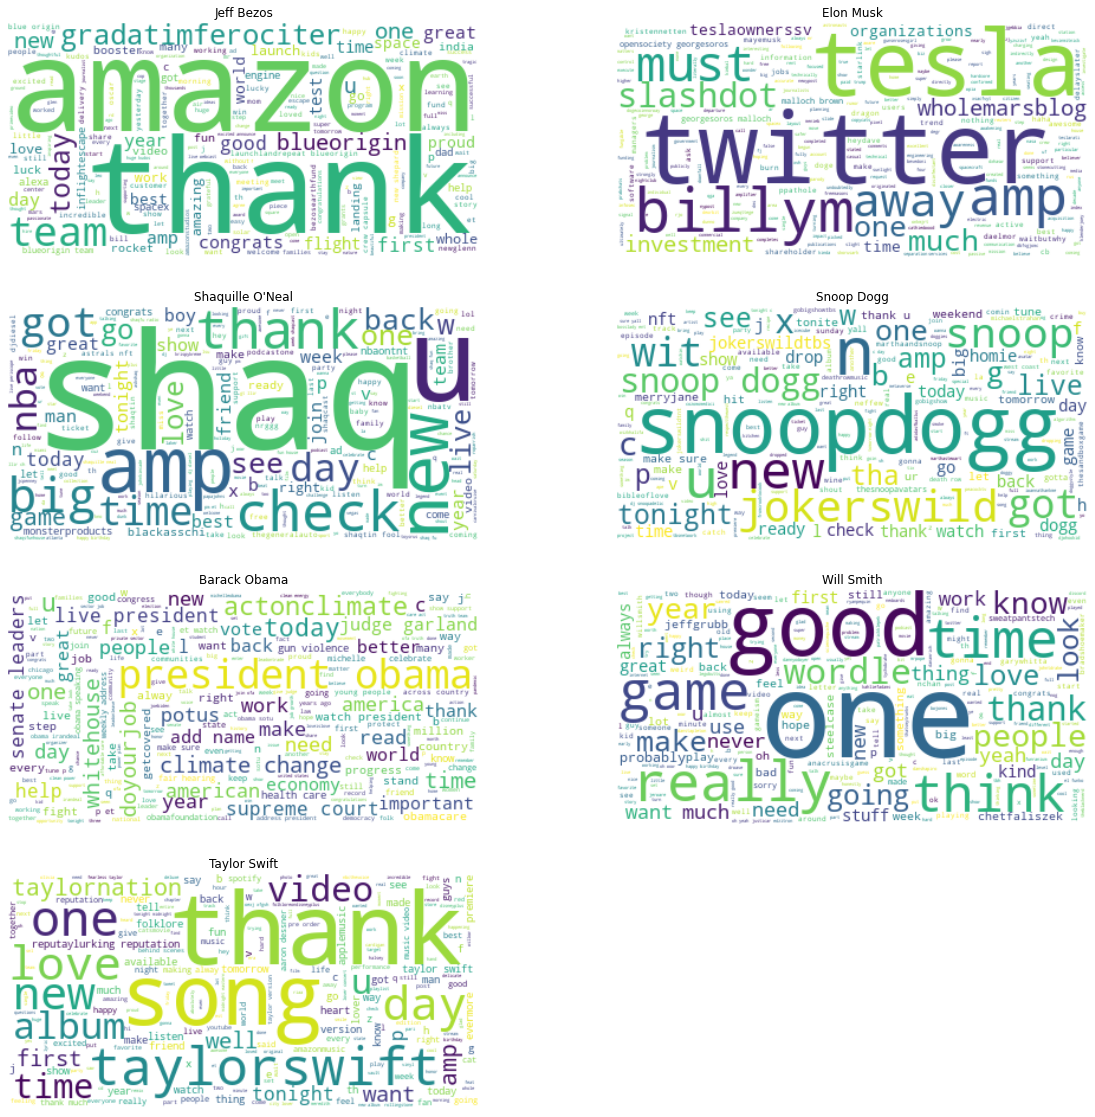

In [95]:
# create a wordcloud for each name and plot all of them in a grid
import matplotlib.pyplot as plt
from wordcloud import WordCloud

plt.figure(figsize=(20, 20))
for i, name in enumerate(columns):
    # create a word cloud for each name
    plt.subplot(4, 2, i+1)
    wordcloud = WordCloud(background_color='white', max_words=5000, contour_width=3, contour_color='steelblue')
    wordcloud.generate(df_strings[name])
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(name)
plt.show()
